# Interactive DPC

In [29]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

import abtem
import dask
import ase
from ase.cluster.cubic import FaceCenteredCubic
import py4DSTEM

abtem.config.set({"dask.lazy":False});
plt.rcParams['text.color']='white'
plt.rcParams['xtick.labelcolor']='white'
plt.rcParams['xtick.color']='white'
plt.rcParams['ytick.labelcolor']='white'
plt.rcParams['ytick.color']='white'
plt.rcParams['axes.labelcolor']='white'
plt.rcParams['axes.edgecolor']='white'

In [30]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
lc = 4.08
atoms = FaceCenteredCubic('Au', surfaces, layers, latticeconstant=lc)

atoms.cell = [48,48,30]
atoms.center()

## Widget

In [31]:
doses = np.append(np.geomspace(1e2,1e4,7),np.inf)
semiangles = np.linspace(5,30,6)

ensemble_axes_metadata = [
    abtem.core.axes.NonLinearAxis(label="dose",units="e",values=doses),
    abtem.core.axes.ParameterAxis(label="CSA",units="mrad",values=semiangles),
]

metadata = {
    'energy':60e3,
    'reciprocal_space': False,
}

sampling = (0.375,0.375)

coms = abtem.Images(
    np.load("data/precomputed-noisy-coms-AUNP.npy"),
    sampling,
    ensemble_axes_metadata,
    metadata
)

In [32]:
style = {
    'description_width': 'initial',
}

layout_half = ipywidgets.Layout(width="335px",height="30px")
layout_third = ipywidgets.Layout(width="225px",height="30px")

recon_toggle = ipywidgets.ToggleButton(
    value=False,
    description="show reconstruction",
    style = style,
    layout = layout_third,
)

integrate_toggle = ipywidgets.ToggleButton(
    value=False,
    description="integrate center-of-mass",
    style = style,
    layout = layout_third,
)

atoms_toggle = ipywidgets.ToggleButton(
    value=False,
    description="show ground-truth atoms",
    style = style,
    layout = layout_third,
)

semiangle_slider = ipywidgets.IntSlider(
    min=5,
    max=30,
    step=5,
    value=10,
    description="convergence semiangle [mrad]",
    style = style,
    layout = layout_half,
)

dose_slider = ipywidgets.SelectionSlider(
    options=[(f"{dose:.0f}", i) for i,dose in enumerate(doses)],
    value=7,
    description="total dose [e]",
    style = style,
    layout = layout_half,
)

In [33]:
potential = abtem.Potential(
    atoms,
    gpts=(192,192),
    slice_thickness=30,
).build(
)

In [34]:
probe = abtem.Probe(
    energy=60e3,
    semiangle_cutoff=semiangle_slider.value,
).match_grid(
    potential
)

In [35]:
index = [96,-48]

arrays_to_mutate = [
    index, # pos
    probe, # probe
]

In [36]:
pos = np.array([arrays_to_mutate[0]])*potential.sampling[0]
custom_scan = abtem.CustomScan(pos)

exit_wave = arrays_to_mutate[1].multislice(
    potential,
    custom_scan,
)

dp = exit_wave.diffraction_patterns(max_angle='valid')
dp = dp**0.5
dp._array = py4DSTEM.visualize.return_scaled_histogram_ordering(dp.array,normalize=True)[0]
com_mrad = (np.array(py4DSTEM.process.utils.get_CoM(dp.array)) - (np.array(dp.array.shape) + 0.5)//2) * np.array(probe.angular_sampling)

rgb = py4DSTEM.visualize.Complex2RGB(exit_wave.array.T,power=2,vmin=0,vmax=0.975)
alpha = py4DSTEM.visualize.return_scaled_histogram_ordering(np.abs(exit_wave.array.T)**2,normalize=True,vmin=0,vmax=0.975)[0]

rgba = np.zeros(exit_wave.gpts+(4,))
rgba[:,:,:3] = rgb
rgba[:,:,3] = alpha

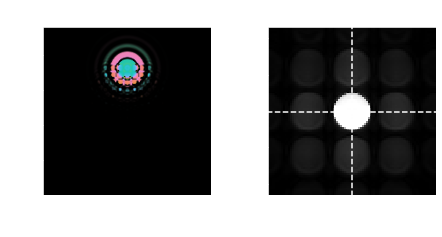

In [37]:
dpi = 72
with plt.ioff():
    fig,axs = plt.subplots(1,3,figsize=(675/dpi,225/dpi),dpi=dpi)

axs[0].patch.set_facecolor('black')
abtem.show_atoms(atoms,scale=1,ax=axs[0],zorder=-1,tight_limits=True,title='complex exit wave')
axs[0].collections[0].set_visible(False)

axs[0].imshow(
    rgba,
    extent=[0,48,0,48],
    origin='lower'
)

dp.show(
    cmap='gray',
    units='mrad',
    title="diffraction pattern",
    ax=axs[1]
)
vlines = axs[1].vlines(com_mrad[0],-60,60,color='white',linestyle='--')
hlines = axs[1].hlines(com_mrad[1],-60,60,color='white',linestyle='--')

py4DSTEM.show_complex(
    coms[-1,0].array.T,
    origin='lower',
    extent=[0,48,0,48],
    cbar=False,
    figax=(fig,axs[2]),
    cmap='magma',
    title="CoM reconstruction"
)
axs[2].xaxis.tick_bottom()
axs[2].set(xlabel=axs[0].get_xlabel(),ylabel=axs[0].get_ylabel())
axs[2].set_visible(False)

fig.patch.set_alpha(0)
fig.tight_layout()

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '680px'
fig.canvas.layout.height = "260px"
fig.canvas.toolbar_position = 'bottom'
fig

In [38]:
def update_plots():
    """ """
    index_i, index_j = arrays_to_mutate[0]
    probe = arrays_to_mutate[1]
    
    pos = np.array([[index_i, index_j]])*potential.sampling[0]
    custom_scan = abtem.CustomScan(pos)
    
    exit_wave = probe.multislice(
        potential,
        custom_scan,
    )
    
    dp = exit_wave.diffraction_patterns(max_angle='valid')
    if dose_slider.value < 7:
        dp = dp.poisson_noise(total_dose=doses[dose_slider.value])
    
    dp = dp**0.5
    dp._array = py4DSTEM.visualize.return_scaled_histogram_ordering(dp.array,normalize=True)[0]
    com_mrad = (np.array(py4DSTEM.process.utils.get_CoM(dp.array)) - (np.array(dp.array.shape) + 0.5)//2) * np.array(probe.angular_sampling)

    rgb = py4DSTEM.visualize.Complex2RGB(exit_wave.array.T,power=2,vmin=0,vmax=0.975)
    alpha = py4DSTEM.visualize.return_scaled_histogram_ordering(np.abs(exit_wave.array.T)**2,normalize=True,vmin=0,vmax=0.975)[0]
    
    rgba = np.zeros(exit_wave.gpts+(4,))
    rgba[:,:,:3] = rgb
    rgba[:,:,3] = alpha
    
    axs[0].images[0].set_data(rgba)
    axs[1].images[0].set_data(dp.array)
    
    vlines.set_segments([np.array([[com_mrad[0],-60],[com_mrad[0],60]])])
    hlines.set_segments([np.array([[-60,com_mrad[1]],[60,com_mrad[1]]])])
    
    fig.canvas.draw_idle()
    return None

def update_com_plot(integrate=False):
    """ """
    dose_index = dose_slider.value
    semiangle_index = semiangle_slider.value//5 - 1
    com = coms[dose_index,semiangle_index]

    if integrate:
        array = py4DSTEM.visualize.return_scaled_histogram_ordering(com.integrate_gradient().array.T,normalize=True)[0]
    else:
        array = py4DSTEM.visualize.Complex2RGB(com.array.T)
    axs[2].images[0].set_data(array)
    fig.canvas.draw_idle()
    return None

def onmove(event):
    """ """
    pos = np.array([event.xdata,event.ydata])
    if pos[0] is not None:
        pos = np.mod(np.floor(pos / potential.sampling[0]).astype("int"),potential.gpts).tolist()
        arrays_to_mutate[0] = pos
        update_plots()
    return None

cid = fig.canvas.mpl_connect('motion_notify_event',onmove)

def update_semiangle(change):
    """ """
    semiangle = change['new']
    
    probe = abtem.Probe(
        energy=60e3,
        semiangle_cutoff=semiangle,
    ).match_grid(
        potential
    )

    arrays_to_mutate[1] = probe
    update_plots()
    update_com_plot(integrate_toggle.value)
    return None

semiangle_slider.observe(update_semiangle,"value")

def update_dose(change):
    """ """
    update_plots()
    update_com_plot(integrate_toggle.value)
    return None

dose_slider.observe(update_dose,"value")

def toggle_recon(change):
    """ """
    visibility = change['new']
    axs[2].set_visible(visibility)
    fig.canvas.draw_idle()
    return None

recon_toggle.observe(toggle_recon,"value")

def toggle_icom(change):
    """ """
    integrate = change['new']
    update_com_plot(integrate)
    axs[2].set(title="iCoM reconstruction" if integrate else "CoM reconstruction")
    return None

integrate_toggle.observe(toggle_icom,"value")

def toggle_atoms(change):
    """ """
    show_atoms = change['new']
    axs[0].collections[0].set_visible(show_atoms)
    fig.canvas.draw_idle()
    return None

atoms_toggle.observe(toggle_atoms,"value")

In [39]:
#| label: app:center-of-mass-imaging

ipywidgets.VBox(
    [
        ipywidgets.HBox([semiangle_slider,dose_slider]),
        ipywidgets.HBox([atoms_toggle,recon_toggle,integrate_toggle]),
        fig.canvas
    ],
    layout=ipywidgets.Layout(
        align_items="center"
    )
)